In [1]:
import ugradio
import numpy as np

import ugradio.pico as pico
import ugradio.dft as dft
import ugradio.doppler as doppler
import ugradio.nch as nch
import ugradio.timing as timing

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, FloatSlider, Layout

import astropy
import unittest

from ugradio import gauss
from scipy.optimize import fmin 

from astropy import units as u
from astropy import constants
import copy

In [2]:
cold_data_2 = np.load('../Data/50mV cold data.npz')
cal_data_2 = np.load('../Data/50mV data with rain.npz')

cold_data = cold_data_2['arr_0'][0] - (cold_data_2["arr_0"][1]*5/4*1j) #SKY
cal_data = cal_data_2['arr_0'][0] - (cal_data_2["arr_0"][1]*5/4*1j) #RAIN 

cold_data.shape = (-1, 2000)
cal_data.shape = (-1, 2000)

In [3]:
freq = np.fft.fftfreq(cold_data.shape[1], 1/62.5e6)
freq = np.fft.fftshift(freq)/1e6

blocks = 8000
avg_power_array = []
for n in range (0, blocks):
    data_new = cold_data[n]
    ft = np.fft.fft(data_new)
    ft = np.fft.fftshift(ft)
    power = abs(ft)**2
    avg_power_array.append(power)
    
avg_power_array = np.mean(avg_power_array, axis = 0)
s_cold = avg_power_array

In [4]:
cal_freq = np.fft.fftfreq(cal_data.shape[1], 1/62.5e6)
cal_freq = np.fft.fftshift(cal_freq)/1e6

blocks = 800
avg_rain_power_array = []
for n in range (0, blocks):
    data_new = cal_data[n]
    ft = np.fft.fft(data_new)
    ft = np.fft.fftshift(ft)
    power = abs(ft)**2
    avg_rain_power_array.append(power)
    
avg_rain_power_array = np.mean(avg_rain_power_array, axis=0)
s_cal = avg_rain_power_array

In [5]:
galactic_data_source = np.load('../Data/Galaxy Data 1000.npz')
galactic_data = galactic_data_source['arr_0'][0] - (galactic_data_source["arr_0"][1]*5/4*1j)

# resize blocks
galactic_data.shape = (-1, 2000)
galactic_data.shape

(8000, 2000)

In [6]:
# GALACTIC DATA, S_ON BECAUSE WE ARE OBSERVING HYDROGEN LINE
galactic_freq = np.fft.fftfreq(galactic_data.shape[1], 1/62.5e6)
galactic_freq = np.fft.fftshift(galactic_freq)/1e6

blocks = 8000
avg_galactic_power_array = []
for n in range (0, blocks):
    data_new = galactic_data[n]
    ft = np.fft.fft(data_new)
    ft = np.fft.fftshift(ft)
    power = abs(ft)**2
    avg_galactic_power_array.append(power)
    
avg_galactic_power_array = np.mean(avg_galactic_power_array, axis = 0)
s_on = avg_galactic_power_array
g_freq = galactic_freq + 1230 + 190

In [7]:
s_off_avg = np.mean(s_on[800:990])
s_off_avg

26680638526.057976

In [8]:
# temperature
T_rx = 300 #kelvin
T_sky = 10 #between 10-100K
T_sys = T_rx - T_sky
filtered_s_cold = np.array([s for s in s_cold if not (g_freq[list(s_cold).index(s)]<1390 or g_freq[list(s_cold).index(s)]>1451 or (g_freq[list(s_cold).index(s)]< 1421 and g_freq[list(s_cold).index(s)]>1419))])
filtered_s_cal = np.array([s for s in s_cal if not (g_freq[list(s_cal).index(s)]<1390 or g_freq[list(s_cal).index(s)]>1451 or (g_freq[list(s_cal).index(s)]< 1421 and g_freq[list(s_cal).index(s)]>1419))])
print(len(filtered_s_cold), len(filtered_s_cal))
filtered_freq = np.fft.fftfreq(filtered_s_cold.shape[0], 1/62.5e6)
filtered_freq = np.fft.fftshift(filtered_freq)/1e6

1890 1890


In [9]:
s_line = s_on / s_off_avg  #s_off=s_cold #GALACTIC POWER SPECTRA / SKY POWER SPECTRA #probably wrong. ratio of on observation (hydrogen there), over off observation (no H)
G = T_sys/(np.sum(filtered_s_cal - filtered_s_cold)) * np.sum(filtered_s_cold)
T_line = (s_line - 1) * G #power spectra in temperature units
T_line[1000] = 0
print("Gain G = " + str(G))

Gain G = 465.9025664952673


## Create Calibrated Spectrum : Mel 

In [10]:
calibrated_data = T_line
list1 = calibrated_data.tolist()
list1.remove(max(list1))
nu_1 = g_freq[list1.index(max(list1))+1]
nu_0 = 1420.4
delta_nu = nu_1 - nu_0
c = 2.99792458 * 10**8

In [11]:
delta_nu

0.13124999999990905

In [12]:
doppler_velocity = - delta_nu/nu_0*c/1000
doppler_v_axis = -(g_freq-1420.4)/1420.4*c/1000

<IPython.core.display.Javascript object>


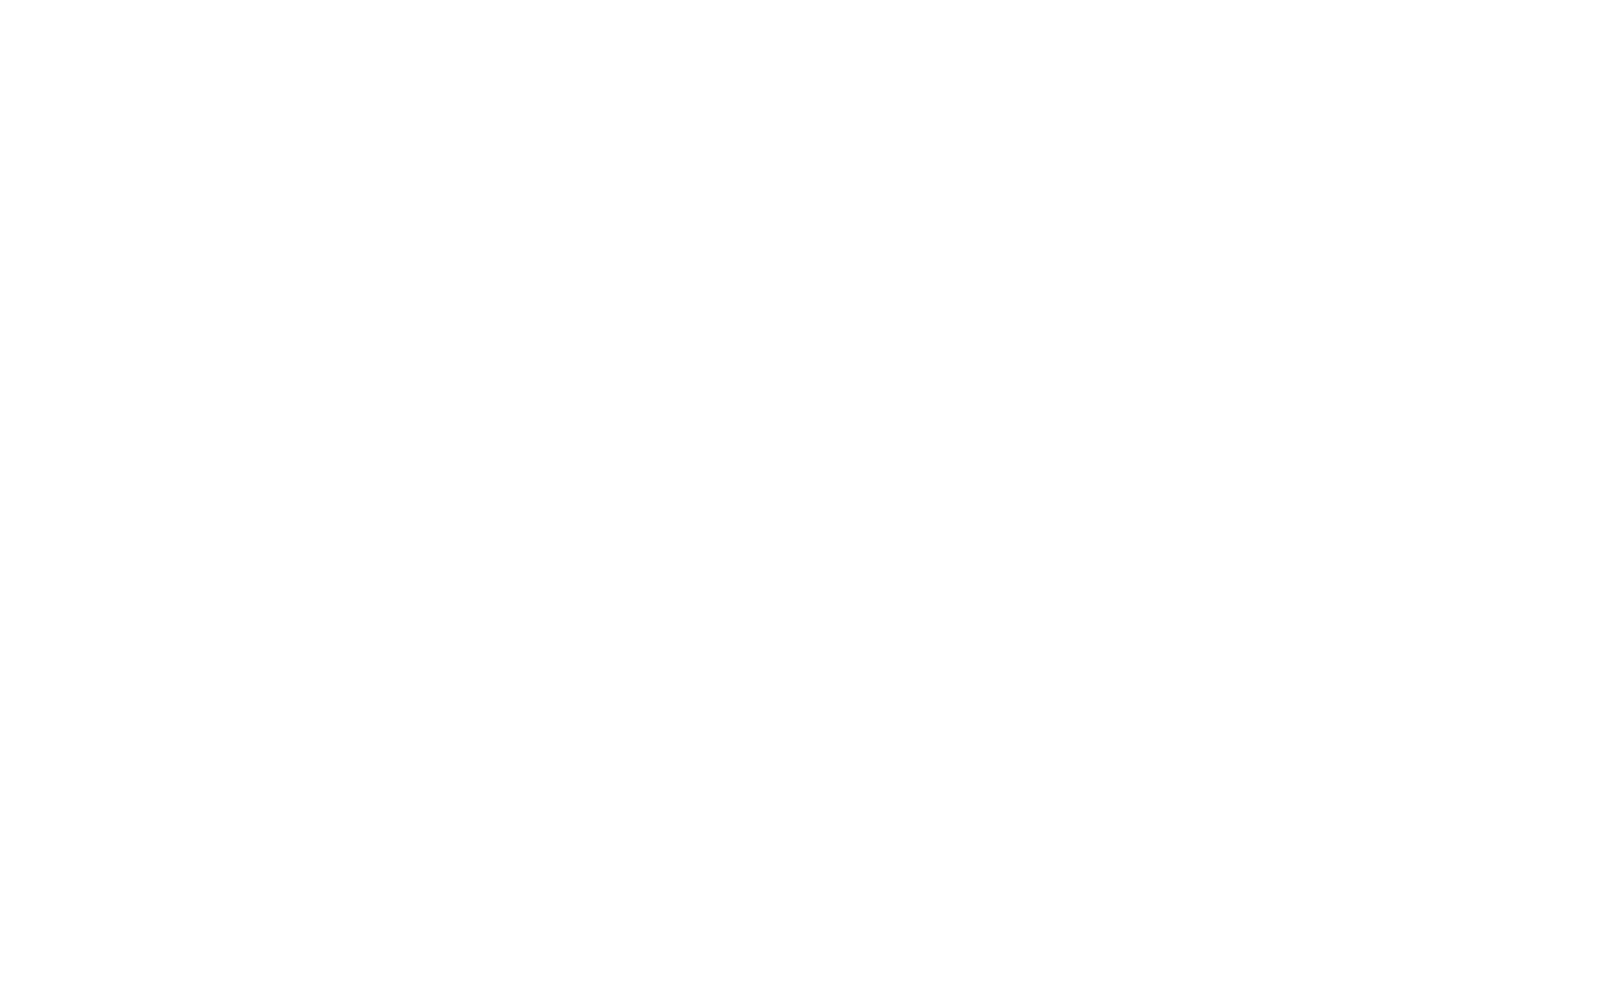

In [13]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(doppler_v_axis, T_line, "r", label="s_on")
plt.xlabel("Velocity (km/s)", fontsize=15)
plt.ylabel("Brightness Temperature (K)", fontsize=15)
plt.title("Calibrated Galactic Data over Observed Doppler Velocity", fontsize=15)
#plt.yscale("log")
plt.vlines(doppler_velocity, ymin=-200, ymax=100, linestyle="dashed", linewidth=.5, label="Doppler Velocity")
plt.legend(fontsize=15)

## Calculate Doppler Correction

In [14]:
dec = nch.lat
jd = ugradio.timing.julian_date(1613674800)
ra = ugradio.timing.lst(jd)
v = ugradio.doppler.get_projected_velocity(ra, dec, jd)
v_float = v.to_value('km/s')
v_float

-19.943701007675738

In [15]:
dist_to_sun = 1.5e8 #km
orbit_dist = 2*np.pi*dist_to_sun
orbit_v = orbit_dist/(np.pi*1e7) #60*60*24*365
galactic_orbit_v = 220 #km/s
orbit_v # maximum error contribution from orbital velocity

29.999999999999996

<IPython.core.display.Javascript object>


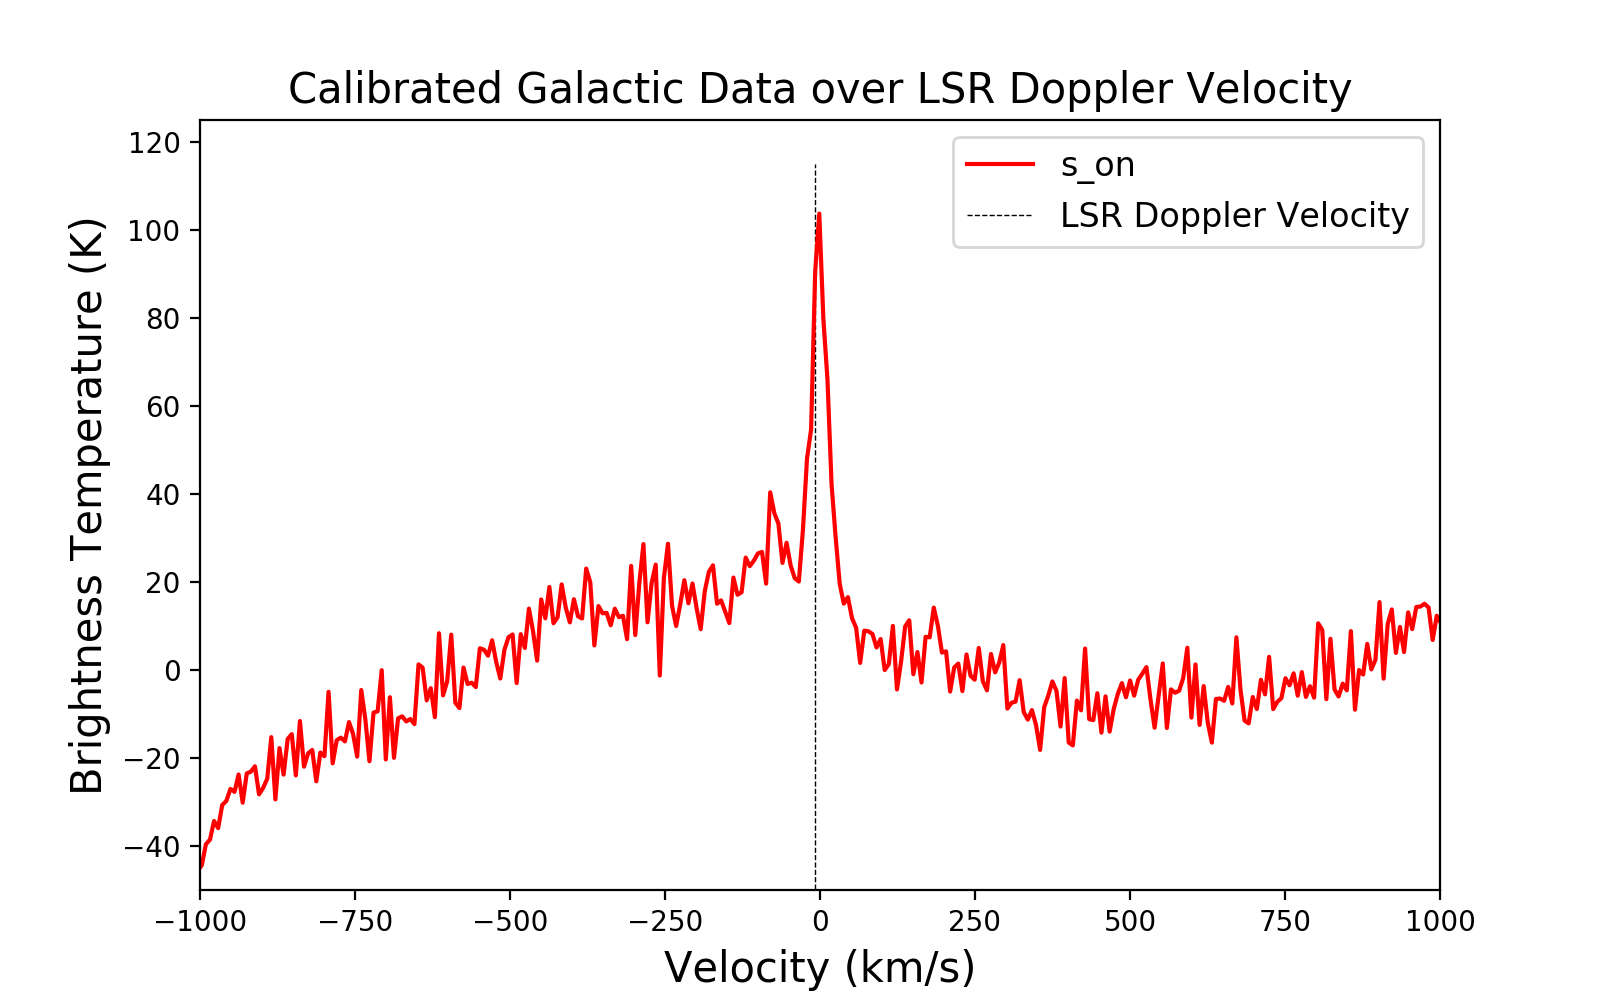

In [16]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(doppler_v_axis - v_float, T_line, "r", label="s_on")
plt.xlabel("Velocity (km/s)", fontsize=15)
plt.ylabel("Brightness Temperature (K)", fontsize=15)
plt.title("Calibrated Galactic Data over LSR Doppler Velocity", fontsize=15)
#plt.yscale("log")
plt.xlim(-1000,1000)
plt.ylim(-50,125)
plt.vlines(doppler_velocity-v_float, ymin=-100, ymax=115, linestyle="dashed", linewidth=.5, label="LSR Doppler Velocity")
plt.legend(fontsize=12)

## Create Gaussian Fit

In [17]:
g_freq_fit = g_freq[950:1060]
T_line_fit = T_line[950:1060]

<IPython.core.display.Javascript object>


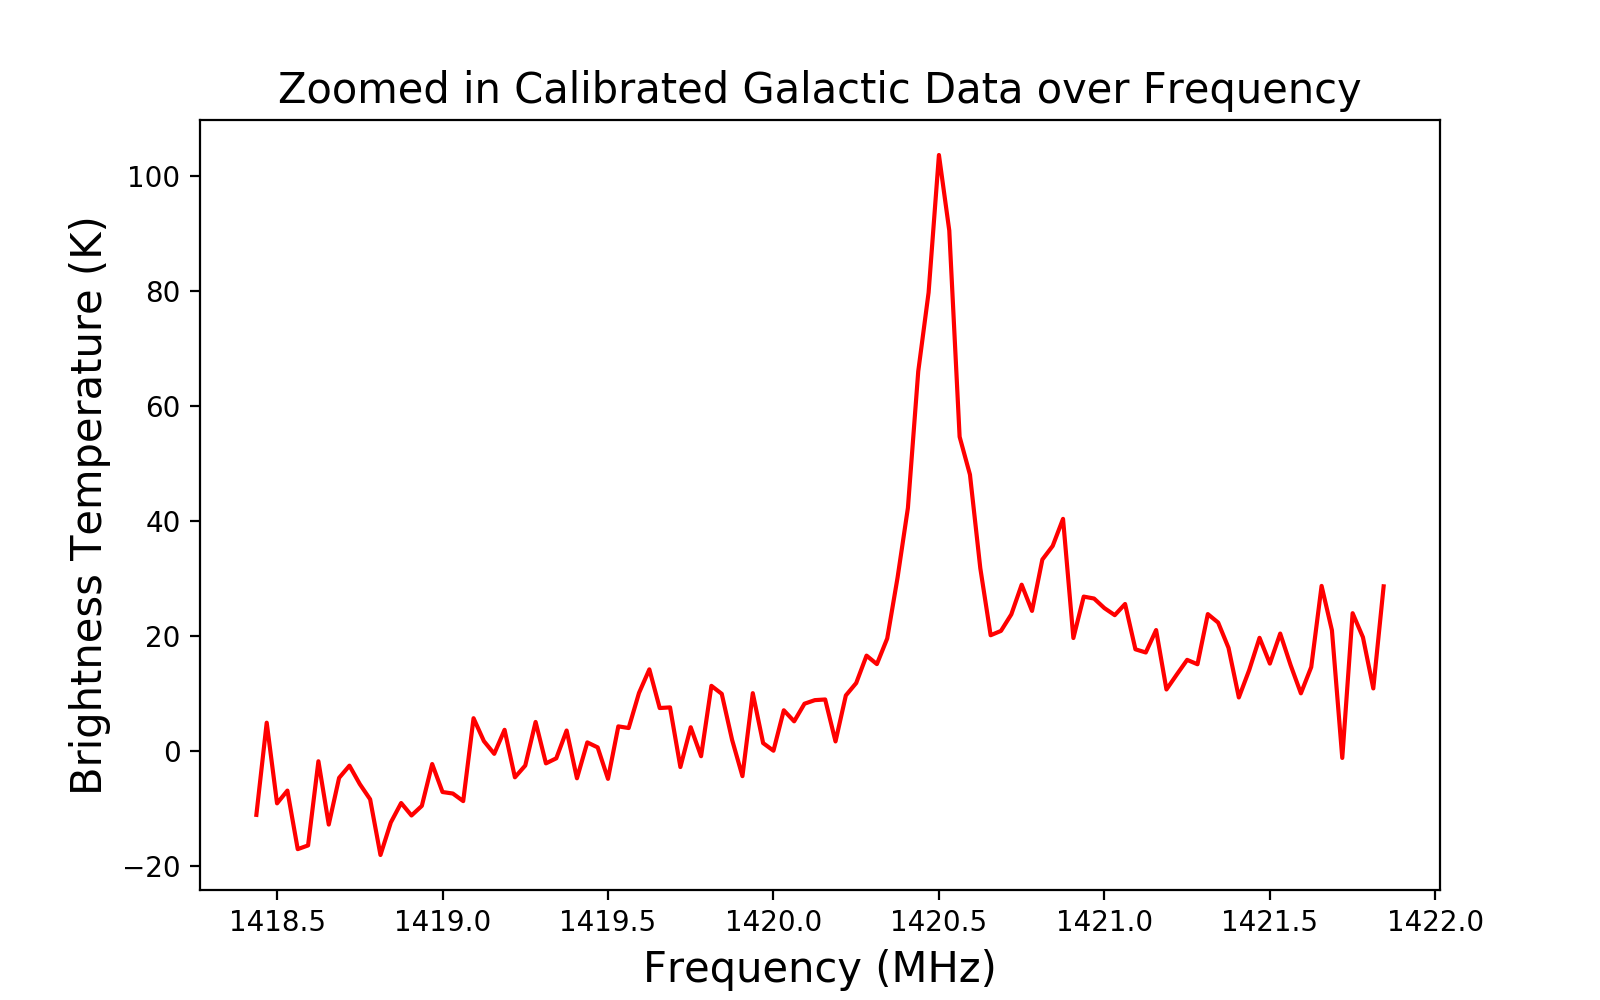

Text(0.5, 1.0, 'Zoomed in Calibrated Galactic Data over Frequency')

In [18]:
plt.figure(figsize=(8,5))
plt.plot(g_freq_fit, T_line_fit, "r", label="s_on")
plt.xlabel("Frequency (MHz)", fontsize=15)
plt.ylabel("Brightness Temperature (K)", fontsize=15)
plt.title("Zoomed in Calibrated Galactic Data over Frequency", fontsize=15)
#plt.legend(fontsize=15)
#plt.yscale("log")
#plt.vlines(g_freq[980], ymin=0, ymax=10e3, linestyle="dashed", linewidth=.5, label="range limit")
#plt.vlines(g_freq[1030], ymin=0, ymax=10e3, linestyle="dashed", linewidth=.5)

In [19]:
d = {'amp' : 100, 'avg':1420.5, 'sig': .1}
poly_fit = np.polyfit(g_freq_fit, T_line_fit, 2)
poly_val = np.polyval(poly_fit, g_freq_fit)
gauss_fit = ugradio.gauss.gaussfit(g_freq_fit, T_line_fit, **d)
gauss_val = ugradio.gauss.gaussval(g_freq_fit, **gauss_fit)

<IPython.core.display.Javascript object>


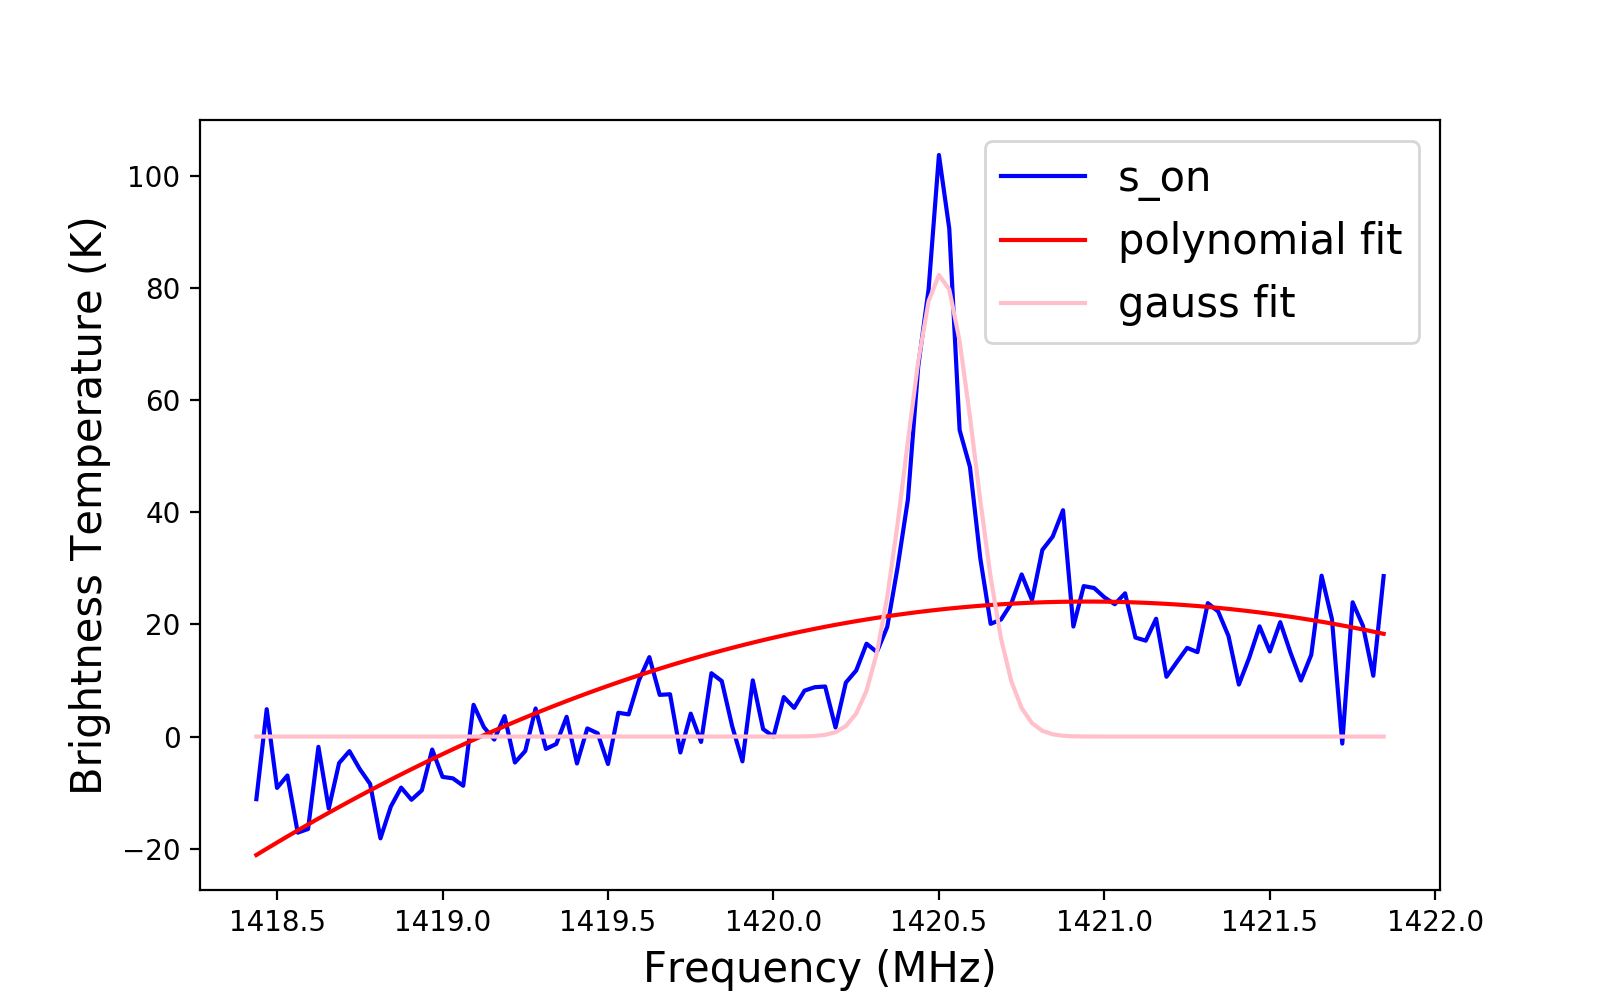

In [20]:
plt.figure(figsize=(8,5))
plt.plot(g_freq_fit, T_line_fit, "b", label="s_on")
plt.plot(g_freq_fit, poly_val, "r", label="polynomial fit")
plt.plot(g_freq_fit, gauss_val, "pink", label="gauss fit")
#plt.plot(g_freq_fit, gauss_val, "y", label="gauss fit")
plt.xlabel("Frequency (MHz)", fontsize=15)
plt.ylabel("Brightness Temperature (K)", fontsize=15)
#plt.title("Zoomed in Calibrated Galactic Data over Frequency", fontsize=25)
plt.legend(fontsize=15)

In [21]:
#wrong poly fit
left_poly = poly_val[0:60]
mid_gauss = gauss_val[61:75]
right_poly = poly_val[76:110]

#left side
g_freq_fit = g_freq[950:1060]
T_line_fit = T_line[950:1060]
poly_fit_left = np.polyfit(g_freq_fit[0:60], T_line_fit[0:60], 2)

poly_val_left = np.polyval(poly_fit_left, g_freq_fit[0:60])

#right side
poly_fit_right = np.polyfit(g_freq_fit[70:110], T_line_fit[70:110], 2)

poly_val_right = np.polyval(poly_fit_right, g_freq_fit[70:110])

#middle
gauss_fit_mid = ugradio.gauss.gaussfit(g_freq_fit[60:70], T_line_fit[60:70], **d)

gauss_val_mid = ugradio.gauss.gaussval(g_freq_fit[60:70], **gauss_fit)

fit_line_new = np.concatenate((poly_val_left,gauss_val_mid,poly_val_right))

In [22]:
#better fit with wrong poly
d = {'amp' : 120, 'avg':1420.5, 'sig': 0.08}
#middle
gauss_fit_mid_new = ugradio.gauss.gaussfit(g_freq_fit[61:70], T_line_fit[61:70], **d)

gauss_val_mid_new = ugradio.gauss.gaussval(g_freq_fit[61:70], **gauss_fit_mid_new)
print(gauss_fit_mid_new)
#sig=stndard deviation of gauss, relate standard deviation to full width half max
#width = 2*((2*ln(2))**(0.5))*sig

#left side better
g_freq_fit = g_freq[950:1060]
T_line_fit = T_line[950:1060]
poly_fit_left2 = np.polyfit(g_freq_fit[0:61], T_line_fit[0:61], 2)

poly_val_left2 = np.polyval(poly_fit_left2, g_freq_fit[0:61])

fit_line_new_2 = np.concatenate((poly_val_left2,gauss_val_mid_new,poly_val_right))

{'amp': array([93.63801803]), 'avg': array([1420.49856593]), 'sig': array([0.07731398])}


In [ ]:
#old subtract with wrong poly
line_new = T_line_fit
subtract_left = line_new[0:61] - poly_val_left2
subtract_right = line_new[70:110] - poly_val_right
fit_line_new_3 = np.concatenate((subtract_left,gauss_val_mid_new,subtract_right))
bright_temp = np.max(fit_line_new_3)
print('Brightness Temperature: ' + str(bright_temp) + ' K')

In [23]:
#fixing poly fit using np.r_
g_freq_fit = g_freq[950:1060]
T_line_fit = T_line[950:1060]

#new_poly_index = np.r_([0:61],[70:110])
#new_poly = poly_val[np.r_[0:61,70:110]]

poly_fit = np.polyfit(g_freq_fit[np.r_[0:61,70:110]], T_line_fit[np.r_[0:61,70:110]], 2)
poly_val2 = np.polyval(poly_fit, g_freq_fit[np.r_[0:61,70:110]])

#middle
gauss_fit_mid = ugradio.gauss.gaussfit(g_freq_fit[61:70], T_line_fit[61:70], **d)

gauss_val_mid = ugradio.gauss.gaussval(g_freq_fit[61:70], **gauss_fit)

fit_line_new5 = np.concatenate((poly_val2[0:61],gauss_val_mid,poly_val2[61:101]))

<IPython.core.display.Javascript object>


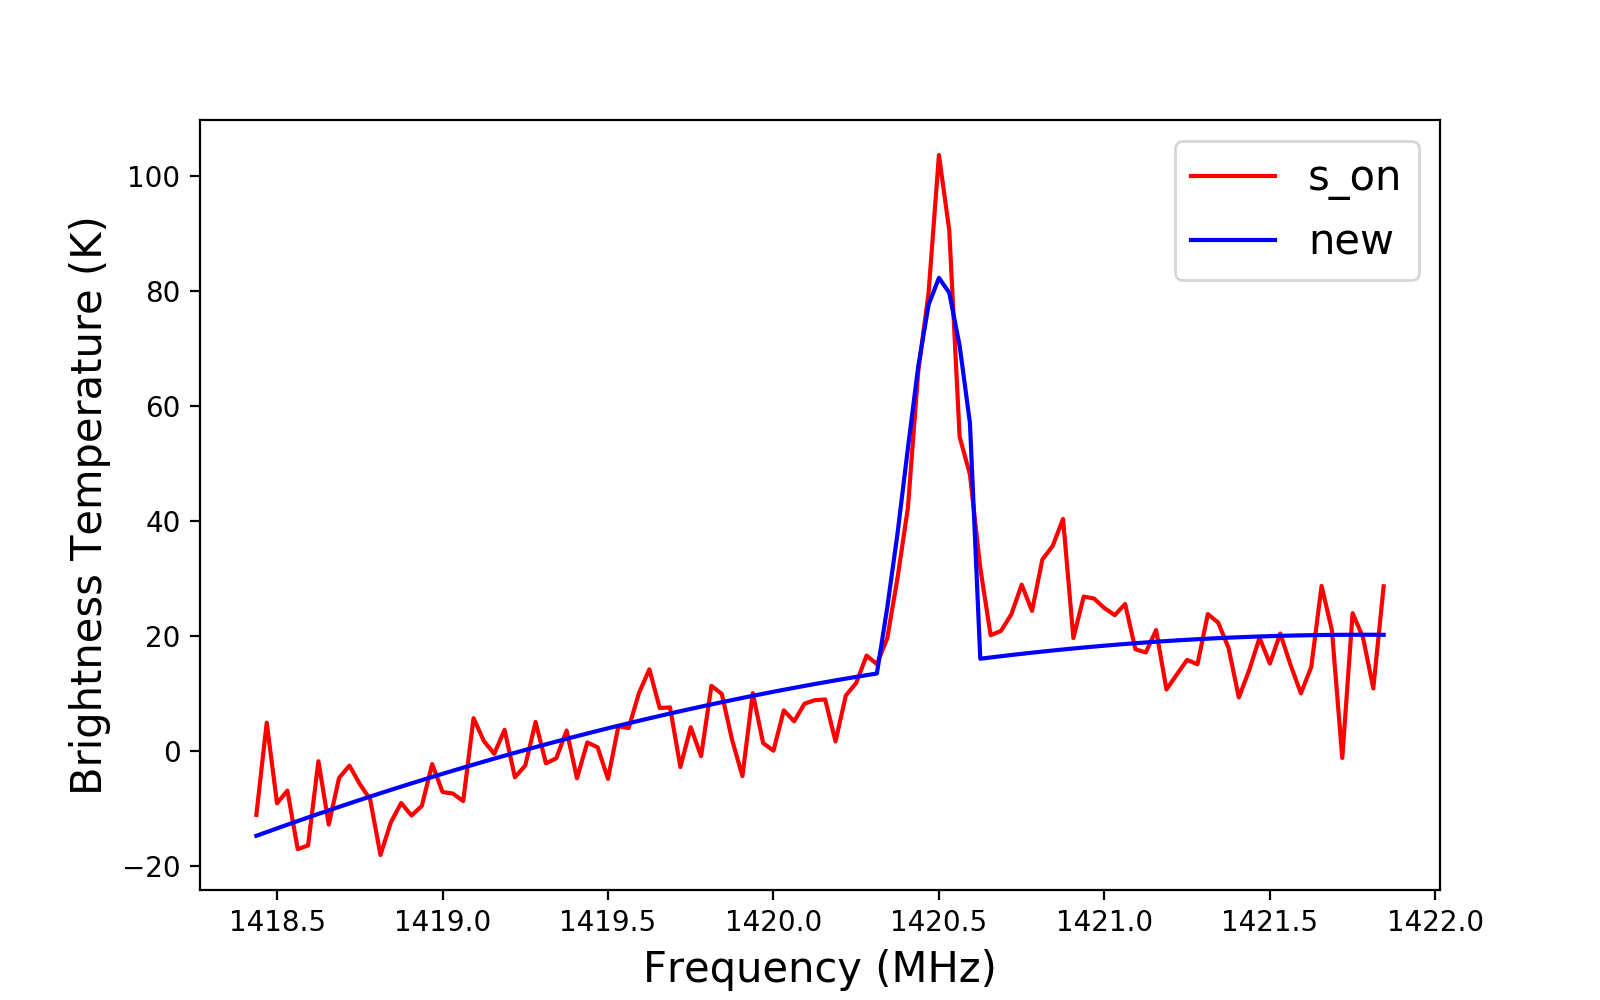

In [24]:
plt.figure(figsize=(8,5))
plt.plot(g_freq_fit, T_line_fit, "r", label="s_on")
plt.plot(g_freq_fit, fit_line_new5, "b", label="new")

plt.xlabel("Frequency (MHz)", fontsize=15)
plt.ylabel("Brightness Temperature (K)", fontsize=15)

plt.legend(fontsize=15)

In [25]:
#better subtract
line_new = T_line_fit
subtract_left = line_new[0:61] - poly_val2[0:61]
subtract_right = line_new[70:110] - poly_val2[61:101]
poly_avg = (poly_val2[61]+poly_val[62])/2
subtract_mid = line_new[61:70] - poly_avg
fit_line_new_3 = np.concatenate((subtract_left,subtract_mid,subtract_right))
bright_temp = np.max(fit_line_new_3)
print('Brightness Temperature: ' + str(bright_temp) + ' K')

Brightness Temperature: 84.86097498733018 K


<IPython.core.display.Javascript object>


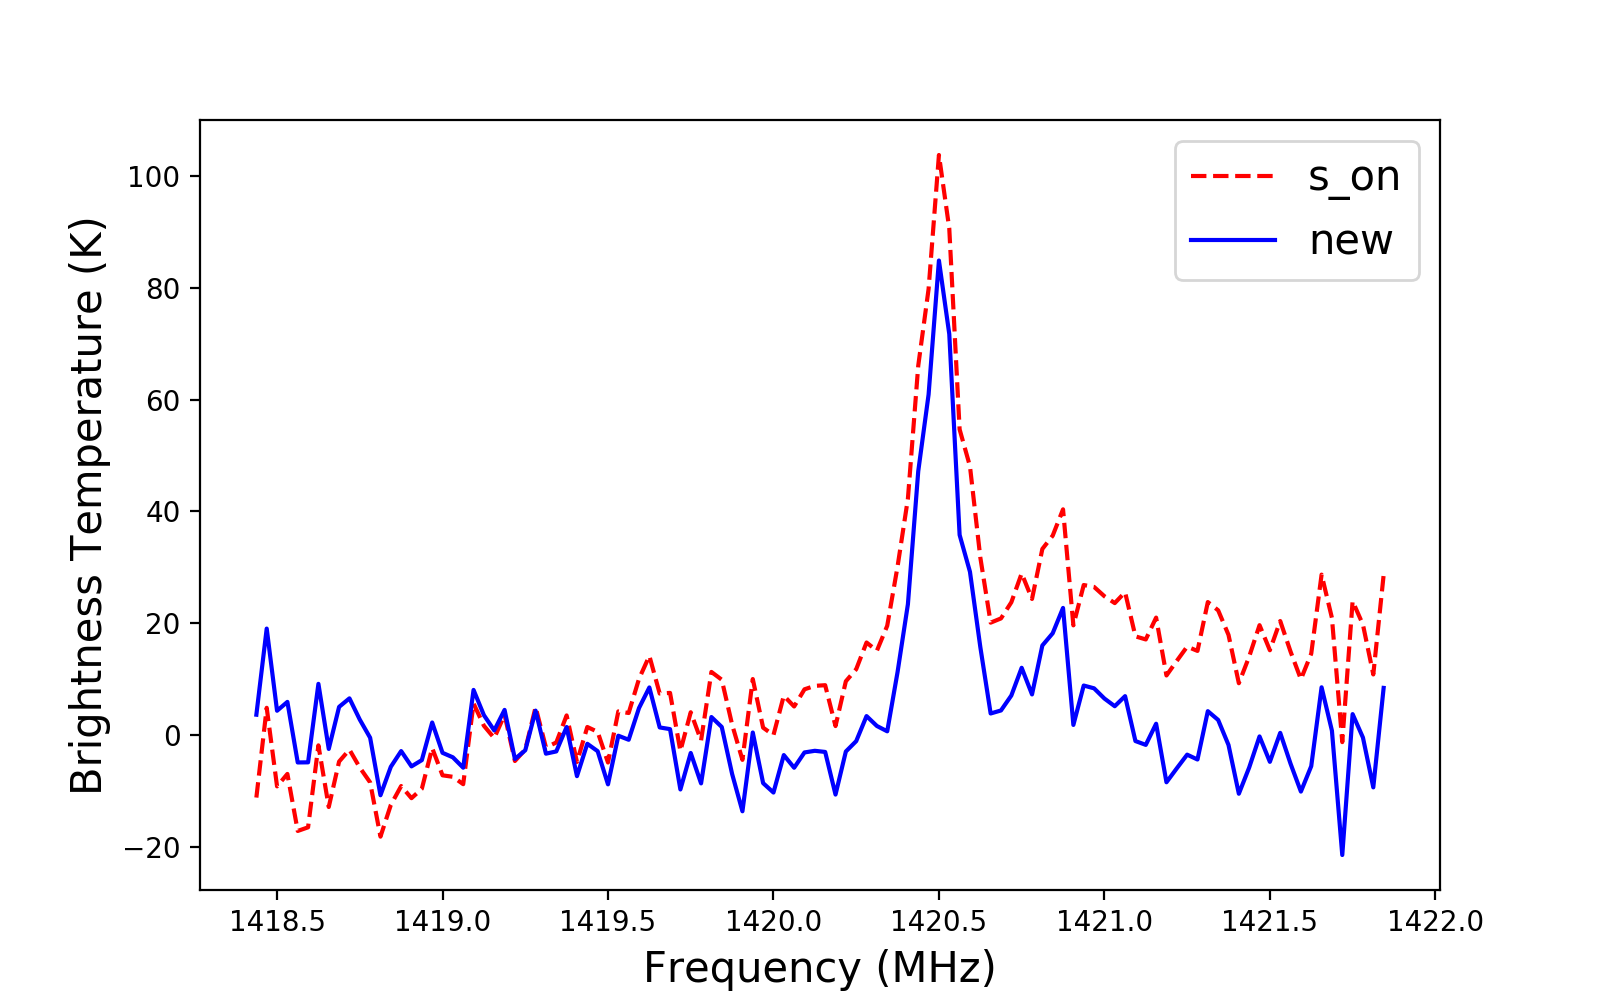

In [26]:
plt.figure(figsize=(8,5))
plt.plot(g_freq_fit, T_line_fit, "r--", label="s_on")
plt.plot(g_freq_fit, fit_line_new_3, "b", label="new")
#plt.plot(g_freq_fit, fit_line_new, "g", label="old")

plt.xlabel("Frequency (MHz)", fontsize=15)
plt.ylabel("Brightness Temperature (K)", fontsize=15)
#plt.title("Zoomed in Calibrated Galactic Data over Frequency", fontsize=25)
plt.legend(fontsize=15)

<IPython.core.display.Javascript object>


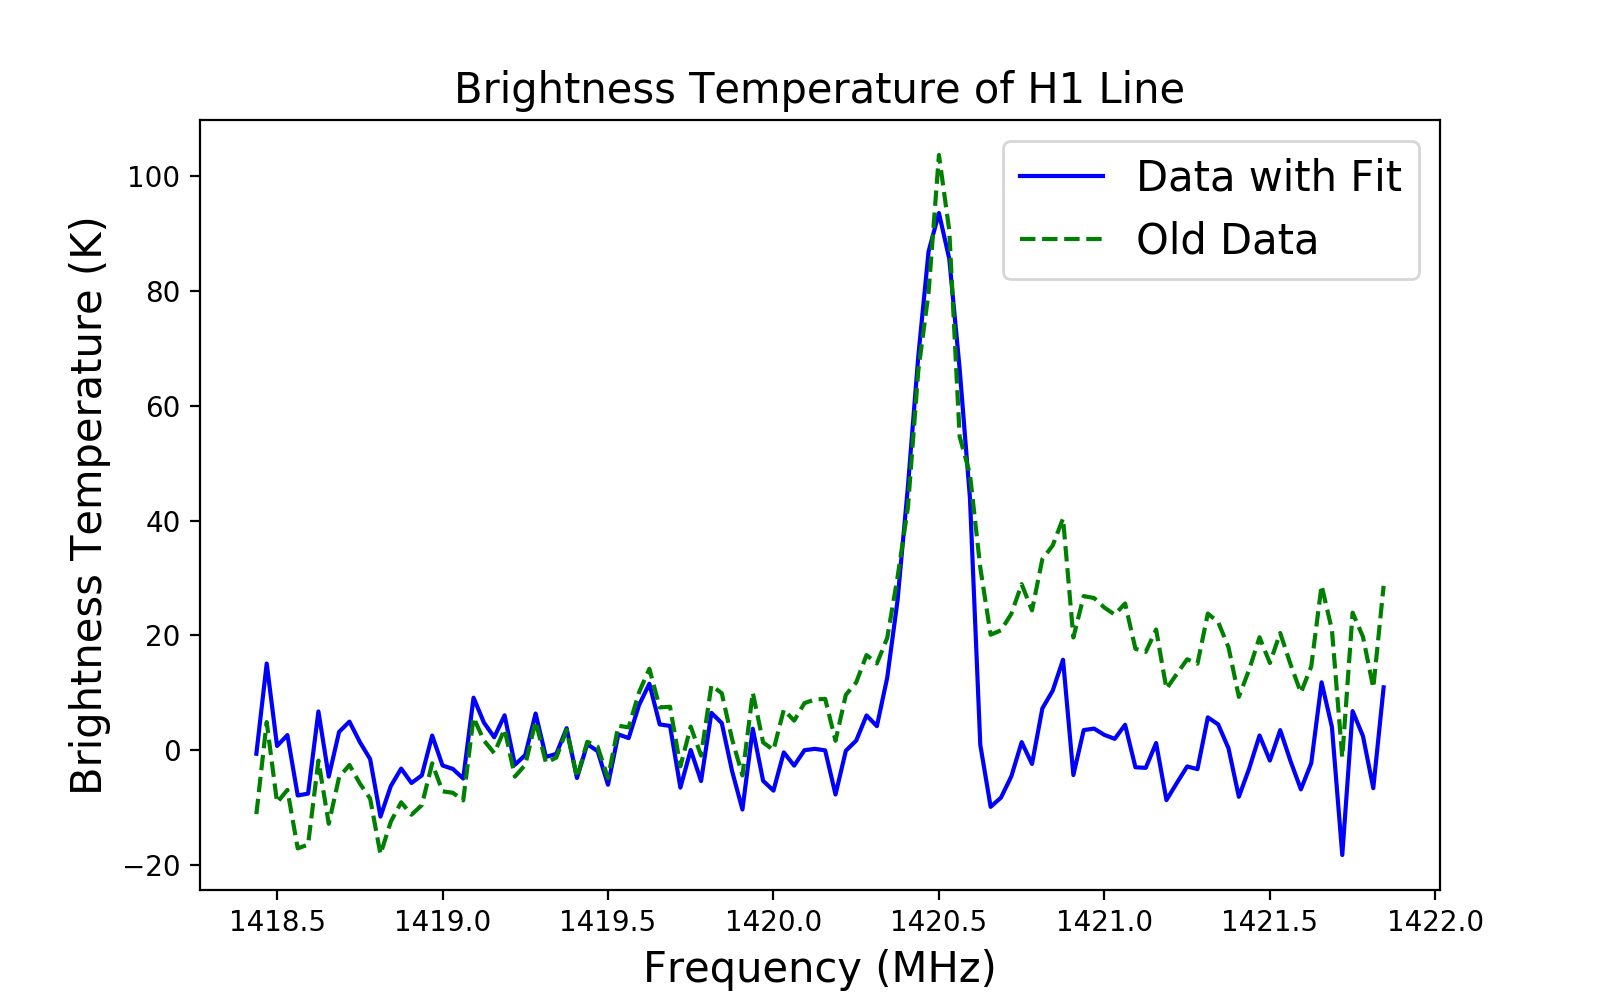

In [29]:
plt.figure(figsize=(8,5))
plt.plot(g_freq_fit, fit_line_new_3, "b", label="Data with Fit")
plt.plot(g_freq_fit, T_line_fit, "g--", label="Old Data")

plt.xlabel("Frequency (MHz)", fontsize=15)
plt.ylabel("Brightness Temperature (K)", fontsize=15)
plt.title("Brightness Temperature of H1 Line", fontsize=15)
plt.legend(fontsize=15)

## Find Kinetic Temp: Madeline

In [30]:
print(gauss_fit_mid_new)

{'amp': array([93.63801803]), 'avg': array([1420.49856593]), 'sig': array([0.07731398])}


 $\Delta \nu = {\frac{\nu _{0}}{c}}\sqrt {{\frac{2kT}{m}}}  \,\!$

In [31]:
np.sqrt(2*1e-16*10000/1e-24)/3e10*1420
#quantify how much temp contributes to width and 
#if temp is reasonable (no) but other things are contributing to the width

0.0669394419523265

In [32]:
sig = 0.07731398
#sig=0.3
delta_nu = sig*u.MHz
delta_nu=delta_nu.to(1/u.s)
nu_0 = 1420.4*u.MHz
nu_0 = nu_0.to(1/u.s)
c = 299792458*u.m/u.s
k =1.380649e-23*u.kg*(u.m**2)/((u.s**2)*u.K)
m=1.6726219e-27*u.kg 
#delta_nu = ((nu_0)/c)*((2*k*temp/m)**0.5)
temp = (((delta_nu*c)/nu_0)**2)*(m/(2*k))
print('Kinetic Temperature: '+ str(temp))

Kinetic Temperature: 16129.490174929073 K


## Find Error: Olivia

In [33]:
_,gauss_fit_error = ugradio.gauss.gaussfit(g_freq_fit[61:70], T_line_fit[61:70], return_cov=True, **d)

In [34]:
gauss_fit_error

array([[ 2.60899555e+01, -2.51249389e-03, -1.84443380e-02],
       [-2.51249389e-03,  2.63783163e-05,  6.66760206e-06],
       [-1.84443380e-02,  6.66760206e-06,  3.48456645e-05]])

In [35]:
#covariance matrix, tells how unceratin parameters are, offdiagonal values show correlation 
#elements in diagonal show variance in amp, avg, sig
#squareroot of elemtns in diagonal is the uncertainty 
amp_error = ((np.diag(gauss_fit_error)[0])**0.5)
avg_error = ((np.diag(gauss_fit_error)[1])**0.5)
sig_error = ((np.diag(gauss_fit_error)[2])**0.5)
print(amp_error)
print(avg_error)
print(sig_error)

5.107832756040398
0.005135982508468316
0.005903021644032389


In [36]:
sigma = np.std(fit_line_new_3[0:20])

In [37]:
sigma

5.907094604800571

In [38]:
gauss_fit_mid = ugradio.gauss.gaussfit(g_freq_fit[61:70], T_line_fit[61:70], **d)

gauss_val_mid = ugradio.gauss.gaussval(g_freq_fit[61:70], **gauss_fit_mid)

In [39]:

fit = copy.copy(gauss_fit_mid)

fit['sig']=np.array([0.08])

## Chi Squared Correct Error

In [40]:
def chisq(ys, mdl, sig):
    return np.sum(np.abs(ys-mdl)**2/sig**2)

chi = chisq(T_line_fit[61:70], gauss_val_mid, sigma)
print(chi)

12.025642204862608


In [41]:
#3 degrees of freedom from gauss fit
#9 data points in the gauss
#measure of how many sigma off on each data point
reduced_chi = chi/(9-3)
reduced_chi

2.0042737008104345

In [42]:
fit = copy.copy(gauss_fit_mid)

fit['sig']=np.array([0.073])
gauss_val_mid = ugradio.gauss.gaussval(g_freq_fit[61:70], **fit)
chi = chisq(T_line_fit[61:70], gauss_val_mid, sigma)
print(chi)
#0.077 +- 0.004 is sig error 

13.758389387823609


In [43]:
fit = copy.copy(gauss_fit_mid)

fit['amp']=np.array([96.63801803])
gauss_val_mid = ugradio.gauss.gaussval(g_freq_fit[61:70], **fit)
chi = chisq(T_line_fit[61:70], gauss_val_mid, sigma)
print(chi)
#93.6 +- 3 is amp error

13.133235423152305


In [44]:
fit = copy.copy(gauss_fit_mid)

fit['avg']=np.array([1420.495])
gauss_val_mid = ugradio.gauss.gaussval(g_freq_fit[61:70], **fit)
chi = chisq(T_line_fit[61:70], gauss_val_mid, sigma)
print(chi)
#1420.498 +- 0.003 is avg error

13.049332286510563


In [45]:
sigma = np.std(fit_line_new_3[0:20])
sigma

5.907094604800571

In [46]:
#gives uncertainty of kinetic temperature 
#take the derivative of kinetic temperature with respect to delta nu and 
#then multiply by standard deviation of delta nu
#temp = (d/delta_nu)*(((delta_nu*c)/nu_0)**2)*(m/(2*k))
der_temp = 2*delta_nu*(((c)/nu_0)**2)*(m/(2*k))
st_dv = sigma*u.MHz
st_dv= st_dv.to(1/u.s)
temp_error = der_temp*st_dv
temp_error

<Quantity 2464713.99843876 K>